In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [92]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
import LinearAlgebra: ldiv!, dot
using Test
using ForwardDiff
using SpecialFunctions
using BenchmarkTools
using TransportMap
using QuadGK
using Polynomials
using Distributions
using Random
using LoopVectorization
using Optim
using NLsolve
using MLDataUtils
using MLDataPattern
using Test
using SparseArrays
using AdaptiveTransportMap: vander, transform!, evaluate, ncoeff, optimize, negative_log_likelihood!, derivative

# using Profile
# using ProfileView
using StaticArrays
using QRupdate
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [189]:
Nx = 3
Ne = 8
m = 20

idx = [0 0 0; 0 0 1; 0 1 0; 0 1 1; 0 1 2; 1 0 0]


Nψ = 6
coeff = [ 0.20649582065364197;
         -0.5150990160472986;
          2.630096893080717;
          1.13653076177397;
          0.6725837371023421;
         -1.3126095306624133]

# coeff = [-0.28829821609289064;
#          -1.1768877197305714;
#           0.40090743090076547];
coeff0 = deepcopy(coeff)
#           1.101330816362896];
C = MapComponent(m, Nx, idx, coeff; α = 1e-6);
C0 = deepcopy(C);

In [203]:
X =  Matrix([ 1.12488     0.0236348   -0.958426;
             -0.0493163   0.00323509  -0.276744;
              1.11409     0.976117     0.256577;
             -0.563545    0.179956    -0.418444;
              0.0780599   0.371091    -0.742342;
              1.77185    -0.175635     0.32151;
             -0.869045   -0.0570977   -1.06254;
             -0.165249   -2.70636      0.548725]')

X = randn(3, 1000)
L = LinearTransform(X)
transform!(L, X);

In [204]:
S = Storage(C.I.f, X)
S̃ = Storage(C.I.f, X);

In [205]:
S.ψnorm

6-element Array{Float64,1}:
 0.9999999999999999
 0.5344708902987484
 0.5311754100835745
 0.28363580983833525
 0.19484747436514968
 0.5322675384691304

In [206]:
sqrt.(sum(S.ψoffψd .^2, dims = 1)/Ne)[1,:]

6-element Array{Float64,1}:
 11.180339887498949
  5.975566213514172
  5.938721624615999
  3.1711447582586065
  2.1784609896231113
  5.9509319911673

In [207]:
ψrescaled = S.ψoffψd*Diagonal(inv.(sqrt.(sum(S.ψoffψd .^2, dims = 1)/Ne)[1,:]))

1000×6 Array{Float64,2}:
 0.0894427  0.101664   0.0996077  0.113322    0.0651013    0.10396
 0.0894427  0.0573938  0.105918   0.0680284   0.154771     0.106059
 0.0894427  0.101697   0.0983545  0.111933   -0.0640354    0.0646014
 0.0894427  0.102983   0.0632135  0.0728506   0.0342252    0.078445
 0.0894427  0.0571906  0.0237194  0.0151804  -0.0346371    0.053669
 0.0894427  0.0973395  0.0407956  0.0444384  -0.0371385    0.104148
 0.0894427  0.0895829  0.10273    0.102986    0.121954     0.105422
 0.0894427  0.0671343  0.105924   0.0795785   0.156091     0.103116
 0.0894427  0.104142   0.106107   0.123658   -0.0438791    0.0718994
 0.0894427  0.0707659  0.0483619  0.0382986   0.0706279    0.0552019
 0.0894427  0.0798292  0.0514944  0.0460021  -0.0709593    0.101812
 0.0894427  0.102913   0.0980605  0.112932    0.0537511    0.0861441
 0.0894427  0.0768725  0.105516   0.0907711   0.149132     0.0920855
 ⋮                                                         ⋮
 0.0894427  0.0832714  0.0

In [208]:
R = UpperTriangular(qr(S.ψoffψd * Diagonal(inv.(S.ψnorm))).R)
F = QRscaling(R, S.ψnorm);

In [209]:
@time res = Optim.optimize(Optim.only_fg!(negative_log_likelihood(S, C, X)), coeff, Optim.LBFGS(),
                           Optim.Options(store_trace=true))

  0.057735 seconds (7.06 k allocations: 50.615 MiB, 39.71% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     1.415869e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.35e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.04e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.78e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.96e-14 ≰ 0.0e+00
    |g(x)|                 = 1.73e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    9
    f(x) calls:    30
    ∇f(x) calls:   30


In [ ]:
S̃ = Storage(C.I.f, X)
J̃ = 0.0
dJ̃ = zeros(Nψ)
c̃oeff0 = F.U*coeff0

S̃.ψoffψd0 .=  S̃.ψoffψd0 * F.Uinv
S̃.ψoffdψxd .= S̃.ψoffdψxd * F.Uinv

@time r̃es = Optim.optimize(Optim.only_fg!(qrnegative_log_likelihood(F, S̃, C, X)), c̃oeff0, Optim.LBFGS(; m = 20),
                           Optim.Options(store_trace=true))

  0.323578 seconds (686.59 k allocations: 76.139 MiB, 2.69% gc time)


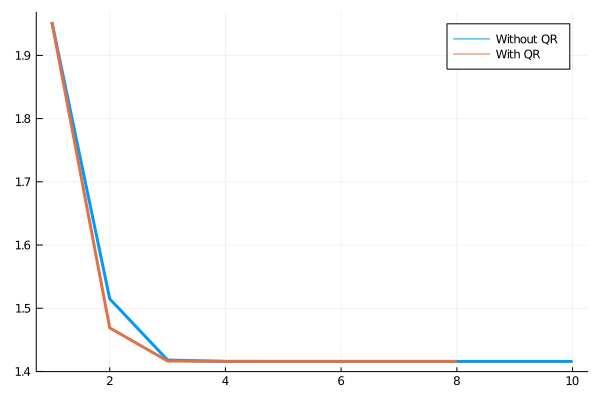

In [211]:
plot(Optim.f_trace(res), linewidth = 3, label = "Without QR")
plot!(Optim.f_trace(r̃es), linewidth = 3, label = "With QR")

In [186]:
res.minimizer

6-element Array{Float64,1}:
  139.73783984774767
 -243.84559444900617
 -226.49818650820487
  392.77706386781705
    6.222175460792006
    4.220511997448957

In [187]:
r̃es.minimizer

6-element Array{Float64,1}:
 -0.28647078233495143
 -1.885348675617844
  0.5275011921688243
 -1.5226210368215827
  0.19366715452911368
 -0.4311504833662969

In [188]:
F.Uinv*r̃es.minimizer

6-element Array{Float64,1}:
  139.73783469809587
 -243.8455859859201
 -226.49817844661422
  392.7770500834483
    6.222175743530571
    4.2205124184476235

In [172]:
J = 0.0
dJ = zeros(Nψ)
@time negative_log_likelihood!(J, dJ, coeff, S, C, X)

  0.000051 seconds (201 allocations: 27.172 KiB)


1.248623234770489

In [173]:
dJ

6-element Array{Float64,1}:
  0.6786930068048251
  0.3838297508563305
  0.40811199630149425
  0.22394334701829668
 -0.12437972101640733
  0.30577805696534427